# **Instalación de dependencias**

In [1]:
# Apache Beam es un modelo unificado de código abierto para definir pipelines de
# procesamiento de datos por lotes o de streaming.
!pip install apache-beam[interactive]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# **Importar Librerias a Colab**

In [2]:
# Importar la API de Google Earth Engine
import ee
# Importar la libreria de visualización de mapas interactivo
import folium
# Importar modulo que generan numeros pseudo aleatorios
import random
from typing import Dict, Iterable, Tuple, List

# Herramientas principales para trabajar con streams y creacion, entrenemiento del modelo
import io
from google.api_core import exceptions, retry
import numpy as np
import requests

import tensorflow as tf
import numpy as np

import apache_beam as beam
from apache_beam.options.pipeline_options import PipelineOptions

from apache_beam.io.filesystems import FileSystems

# Libreria que nbos permite crear imagenes dinamicas
import imageio
from IPython.display import Image
import matplotlib.pyplot as plt

# Libreria para trabajar con archivos
import os

# **Inicializando Google Earth Engine**

In [3]:
# Autenticación para el uso de Google Earth Engine
ee.Authenticate()
# Inicializando la libreria de Google Earth Engine
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=Zn9n__EiiCWn5s6lIJAIxfL3z-NvNxFS9PnGxAExBXY&tc=iUUpxeDJpUyu92afJPf_0tpJ8KTliC3xrSKehF7Q6Xw&cc=n3LirtnTNJOlmm1gM_V8LgB0_nTLEOii_4IY4WeZXxQ

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AdQt8qjBfDxDY-w5m7bOFOaU_5T4OgNtl4GeR2SKPV9RKSVUy7q_n692-5s

Successfully saved authorization token.


In [4]:
# Definimos mediante un diccionario las bandas de clasificación que deseamos
# identificar
CLASSIFICATIONS = {
    "Agua":              "419BDF",
    "Arboles":              "397D49",
    "Hierba":              "88B053",
    "Vegetacion Inundada": "7A87C6",
    "Cultivos":              "E49635",
    "Arbustos y matorral":    "DFC35A",
    "Areas Edificadas":     "C4281B",
    "Suelo abierto":        "A59B8F",
    "Nieve y hielo":       "FFFFFF",
}
# Usando codigos de color ANSI
# https://gist.github.com/mgumiero9/665ab5f0e5e7e46cb049c1544a00e29f
def display_legend():
  reset_color = "\u001b[0m"
  colored = lambda red, green, blue: f"\033[48;2;{red};{green};{blue}m"
  for name, color in CLASSIFICATIONS.items():
    red   = int(color[0:2], 16)
    green = int(color[2:4], 16)
    blue  = int(color[4:6], 16)
    print(f"{colored(red, green, blue)}   {reset_color} {name}")

display_legend()

    Agua
    Arboles
    Hierba
    Vegetacion Inundada
    Cultivos
    Arbustos y matorral
    Areas Edificadas
    Suelo abierto
    Nieve y hielo


## Imagenes de entrada
La adquisición de datos será de las imagenes generadas por los satelites Sentinel-2. Para simplificar el procesamiento el filtrado de las imagenes sera en un intervalo de tiempo determinado ademas filtraremos las imagenes segun el porcentaje de nubosidad y manipularemos la banda QA60 para obtener imagenes sin nubes concentradas y dispersas

In [5]:
def imagen_sentinel2(start_date: str, end_date: str) -> ee.Image:
    """ Devuelve la imagen global de la coleccion 
        Sentinel-2 MSI: instrumento multiespectral, nivel 1C 
        limpia y filtrada 
          * @param {str, str} fechas en las que se realizara las lecturas
          * @return {ee.Image} imagen limpia 
    """

    def mask_sentinel2_clouds(image: ee.Image) -> ee.Image:
        """ Permite actualizar la mascara de las imagenes para limpiar la imagen 
            de nubes.
            * @param {ee.Image} imagen Sentinel-2
            * @return {ee.Image} cloud masked Sentinel-2 image
        """
        # Nubes
        CLOUD_BIT = 10
        # Nubes dispersas
        CIRRUS_CLOUD_BIT = 11
        bit_mask = (1 << CLOUD_BIT) | (1 << CIRRUS_CLOUD_BIT)
        # Ambos operadores binarios deben ser 0 para indicar condiciones atmosfericas limpias
        mask = image.select("QA60").bitwiseAnd(bit_mask).eq(0)
        return image.updateMask(mask)

    return (
        # Seleccionamos la colección: Sentinel-2 MSI: instrumento multiespectral , nivel 1C
        ee.ImageCollection("COPERNICUS/S2")
        # Seleccionamos el periodo de la collección
        .filterDate(start_date, end_date)
        # Seleccionamos el porcentaje de nubes
        .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 20))
        # Aplicamos la mascara de nubes definido arriba
        .map(mask_sentinel2_clouds)
        # Aplicamos la mediana a las imagenes para componer una imagen
        .median()
    )

Dado las imagenes de entrada definidos en el anterior punto ahora nos enfocaremos en 

In [6]:
def cobertura_de_img() -> ee.Image:
    """ Devuelve la imagen global con la nueva clasificación de segmentación 
        para el mapa de cobertura de la colección ESA/WorldCover/v100
          * @param {}
          * @return {ee.Image} imagen con la nueva clasificación
    """
    # Tipos de clase de ESA/WorldCover/v100 (ver documentación)
    fromValues = [10, 20, 30, 40, 50, 60, 70, 80, 90, 95, 100]
    # Nueva designacion de los tipos de clase
    toValues = [1, 5, 2, 4, 6, 7, 8, 0, 3, 3, 7]
    return (
        ee.ImageCollection("ESA/WorldCover/v100")
        # Devuelve la primera entrada de la collección
        .first()
        # Selecciona las bandas
        .select("Map")
        # Reemplazar los tipos de la imagen 
        .remap(fromValues, toValues)
        # Renombrar las bandas de la imagen
        .rename("landcover")
    )

# **Construir el conjunto de datos de entrenamiento y validación**

In [7]:
def sample_random_points(region: Dict[str, float], points_per_region: int = 10) -> Iterable[Tuple[float, float]]:
  for _ in range(points_per_region):
    lat = random.uniform(region["south"], region["north"])
    lon = random.uniform(region["west"], region["east"])
    yield (lat, lon)
#Los conjuntos de datos se extraeran de la Region de islandia
region = {"west": -23.526, "south":  60.537, "east": -15.526, "north":  68.537}
for coords in sample_random_points(region, points_per_region=5):
  print(f"coords: {coords}")

coords: (64.4256557597511, -19.725964284663892)
coords: (68.12407994032183, -16.766533808894334)
coords: (63.194429719348285, -22.366409854233645)
coords: (63.500554259154754, -22.140415643378155)
coords: (65.3591960352492, -19.747975878920936)


# **Determinar la region de interes**

In [8]:
INPUT_BANDS = ["B1", "B2", "B3", "B4", "B5", "B6", "B7", "B8", "B8A", "B9", "B10", "B11", "B12"]
OUTPUT_BANDS = ["landcover"]

@retry.Retry()
def get_patch(image: ee.Image, lat: float, lon: float, bands: List[str], patch_size: int, scale: int) -> np.ndarray:
  """ Devuelve el array numpy de regiones de imagenes obtenidas mediante 
        consulta 
          * @param {
            ee.Image: Imagen del tipo Google Earth Engine
            lat: Latitud del punto de interes
            lon: Longitud del punto de interes
            bands: Lista de bandas
            patch_size: Region de interes
            scale: escala

          }
          * @return {np.array} array de regiones de imagenes en punto flotante
  """
  # Descargar la región de interes 
  # Definimos un punto de interes mediante sus coordendas
  point = ee.Geometry.Point([lon, lat])
  # Definición de la region de interes,  con un 1% de error, mediante un rectangulo 
  # delimitador de 1% de error
  region = point.buffer(scale * patch_size / 2, 1).bounds(1)
  # Obtenemos la url de descarga de la región de interes
  url = image.getDownloadURL({
      "region": region,
      "dimensions": [patch_size, patch_size],
      "format": "NPY",
      "bands": bands,
  })

  # Descargamos la region de interes
  response = requests.get(url)
  # Si la consulta nos da error (error 429) capturar el error y seguir
  if response.status_code == 429:
    raise exceptions.TooManyRequests(response.text)
  # devuelve un objeto HTTPError si se ha producido un error durante la consulta 
  response.raise_for_status()

  print(f"Got patch for {(lat, lon)}")
  # Carga y retorna el numpy array con la respuesta
  return np.load(io.BytesIO(response.content), allow_pickle=True)

def get_training_patch(lat: float, lon: float, bands: List[str] = [], patch_size: int = 16) -> np.ndarray:
    """ Devuelve el np.ndarray de secciones de imagenes 
          * @param {
            lat: Latitud del punto de interes
            lon: Longitud del punto de interes
            bands: Lista de bandas
            patch_size: Region de interes
          }
          * @return {np.array} array de regiones de imagenes en punto flotante
    """
    # A la imagen global limpía le añadimos la nueva designación de bandas
    image = imagen_sentinel2("2020-1-1", "2021-1-1").addBands(cobertura_de_img())
    # Descargamos la region de interes en formato array numpy
    return get_patch(image, lat, lon, bands, patch_size, scale=10)

# ==============================================================================
# Determinar el espacio objetivo para la prueba de las anteriores funciones: Laguna Alalay
# Datos geograficos de la ubicación
lon,lat=-66.13315361745312,-17.400998802272323
bands = INPUT_BANDS + OUTPUT_BANDS
patch = get_training_patch(lat, lon, bands, patch_size=128)
print(f"patch shape={patch.shape} bands={len(patch.dtype)}")
print(f"dtype: {patch.dtype}")

Got patch for (-17.400998802272323, -66.13315361745312)
patch shape=(128, 128) bands=14
dtype: [('B1', '<f8'), ('B2', '<f8'), ('B3', '<f8'), ('B4', '<f8'), ('B5', '<f8'), ('B6', '<f8'), ('B7', '<f8'), ('B8', '<f8'), ('B8A', '<f8'), ('B9', '<f8'), ('B10', '<f8'), ('B11', '<f8'), ('B12', '<f8'), ('landcover', 'u1')]


# **Graficar una imagen para verificar que la region es la correcta**

sentinel2_rgb: uint8 (128, 128, 3)


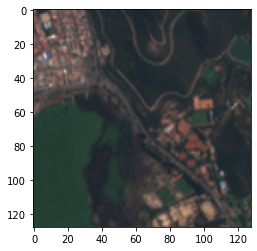

In [9]:
def render_rgb_images(values: np.ndarray, min=0.0, max=1.0) -> np.ndarray:
  """ Normaliza los valores del array a una escala 0 a 255
          * @param {
            values: valores de array 
            min: limite inferior
            max: limite superior
          }
          * @return {np.array} array de regiones de imagenes normalizado
  """
  # Factor de escala
  scaled_values = (values - min) / (max - min)
  # Escalar los valores
  rgb_values = scaled_values * 255
  # Retornar el array con el tipo uint8
  return rgb_values.astype(np.uint8)

def render_sentinel2(patch: np.ndarray, min=0.0, max=3000.0) -> np.ndarray:
  """ Devuelve el array con las bandas necesarias para formar una imagen RGB
          * @param {
            patch: valores de array 
            min: limite inferior
            max: limite superior
          }
          * @return {np.array} array de regiones de imagenes normalizado y con 
                    las bandas RGB
  """
  # Definir las bandas necesarias para graficar la imagen
  red   = patch["B4"]
  green = patch["B3"]
  blue  = patch["B2"]
  # Apilar las imagenes para formar imagenes RGB
  rgb_patch = np.stack([red, green, blue], axis=-1)

  return render_rgb_images(rgb_patch, min, max)

sentinel2_rgb = render_sentinel2(patch, max=4000)

print(f"sentinel2_rgb: {sentinel2_rgb.dtype} {sentinel2_rgb.shape}")
plt.imshow(sentinel2_rgb)

landcover_rgb: uint8 (128, 128, 3)
    Agua
    Arboles
    Hierba
    Vegetacion Inundada
    Cultivos
    Arbustos y matorral
    Areas Edificadas
    Suelo abierto
    Nieve y hielo


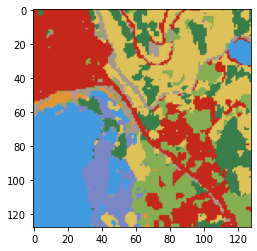

In [10]:
def render_classifications(values: np.ndarray, palette: List[str]) -> np.ndarray:
  """ Devuelve un mapa de colores segun el diccionario de clasificación
          * @param {
            values: valores de array 
            palette: diccionario de clasificacióm
          }
          * @return {np.array} array de regiones de imagenes normalizado y con 
                    las bandas RGB
  """
  # Creamos un mapa de colores a partir de una paleta de colores hexadecimal.
  xs = np.linspace(0, len(palette), 256)
  indices = np.arange(len(palette))
  color_map = np.array([
        np.interp(xs, indices, [int(c[0:2], 16) for c in palette]),  # red
        np.interp(xs, indices, [int(c[2:4], 16) for c in palette]),  # green
        np.interp(xs, indices, [int(c[4:6], 16) for c in palette]),  # blue
  ]).astype(np.uint8).transpose()

  color_indices = (values / len(palette) * 255).astype(np.uint8)
  return np.take(color_map, color_indices, axis=0)

def render_landcover(patch: np.ndarray) -> np.ndarray:
  """ Devuelve un mapa de colores segun el diccionario de clasificación
          * @param {
            patch: valores de array 
          }
          * @return {np.array} array de regiones de imagenes 
  """
  return render_classifications(patch, list(CLASSIFICATIONS.values()))

landcover_rgb = render_landcover(patch["landcover"])

print(f"landcover_rgb: {landcover_rgb.dtype} {landcover_rgb.shape}")
plt.imshow(landcover_rgb)
display_legend()

Guardamos nuestros conjuntos de datos en el formato de TFRecords.

In [11]:
def serialize(patch: np.ndarray) -> bytes:
    features = {
        name: tf.train.Feature(
            float_list=tf.train.FloatList(value=patch[name].flatten())
        )
        for name in patch.dtype.names
    }
    example = tf.train.Example(features=tf.train.Features(feature=features))
    return example.SerializeToString()

serialized = serialize(patch)
print(f"serialized: {type(serialized).__name__} ({len(serialized)})")

serialized: bytes (917799)


Usaremos Apache Beam ya que este nos permite crear pipelines de procesamiento en paralelo.

In [12]:
points_per_region = 4

# Se obtiene el valor desde una variable de entorno si esta disponible.
points_per_region = int(os.environ.get("POINTS_PER_REGION", points_per_region))

In [13]:
patch_size = 8
validation_ratio = 0.1

regions = [
    {"west": -23.52, "south": 60.53, "east": -15.52, "north": 68.53},
    {"west": -67.59, "south": -22.17, "east": -59.59, "north": -14.17},
    {"west": 43.02, "south": -22.58, "east": 51.02, "north": -14.58},
    {"west": 129.60, "south": -20.95, "east": 137.60, "north": -12.95},
    {"west": 23.92, "south": 64.33, "east": 31.92, "north": 72.33},
    {"west": 75.81, "south": 33.26, "east": 83.81, "north": 41.26},
    {"west": 7.73, "south": 51.54, "east": 15.73, "north": 59.54},
    {"west": -73.34, "south": 6.04, "east": -65.34, "north": 14.04},
    {"west": 42.79, "south": 21.07, "east": 50.79, "north": 29.07},
    {"west": 60.45, "south": 63.87, "east": 68.45, "north": 71.87},
]

def split_dataset(element, num_partitions: int) -> int:
  weights = [1 - validation_ratio, validation_ratio]
  return random.choices([0, 1], weights)[0]

beam_options = PipelineOptions([], direct_num_workers=len(regions))
with beam.Pipeline(options=beam_options) as pipeline:
  training_data, validation_data = (
      pipeline
      | "Create regions" >> beam.Create(regions)
      | "Sample random points" >> beam.FlatMap(sample_random_points, points_per_region)
      | "Get patch" >> beam.MapTuple(get_training_patch, bands, patch_size)
      | "Serialize" >> beam.Map(serialize)
      | "Split dataset" >> beam.Partition(split_dataset, 2)
  )

  training_data | "Write training data" >> beam.io.WriteToTFRecord(
      "datasets/training", file_name_suffix=".tfrecord.gz"
  )
  validation_data | "Write validation data" >> beam.io.WriteToTFRecord(
      "datasets/validation", file_name_suffix=".tfrecord.gz"
  )

Got patch for (71.78580167369587, 25.4604339065758)
Got patch for (55.17217808837954, 8.616797533606281)
Got patch for (66.56992205701907, 62.03453908658052)
Got patch for (-16.49011303504921, 46.996231144561214)
Got patch for (66.62351050770926, -18.49721598482508)
Got patch for (-15.9995055829656, 132.37752384527366)
Got patch for (11.891926323892509, -67.15585857864326)
Got patch for (-21.493598521678667, -63.34140973198605)
Got patch for (37.13732238059533, 78.72088724795591)


Got patch for (25.286864466324175, 44.5287287548706)


Got patch for (12.662164580102178, -72.50168319207748)
Got patch for (66.95853610133216, 26.97768247997425)
Got patch for (-17.865361259986727, 43.83705118340843)
Got patch for (36.689618836900884, 75.8513390330512)
Got patch for (67.97298313599151, 66.85378848725401)
Got patch for (-15.68959785690991, -64.51744474571468)
Got patch for (65.55429169860409, -17.73112570882339)
Got patch for (-17.793893554192188, 135.5359850178962)
Got patch for (23.092245965002753, 49.000837316491044)
Got patch for (68.14566733471943, 26.176363935818546)
Got patch for (57.16507678763441, 9.087988690217792)
Got patch for (6.380679836633455, -70.350635316321)


Got patch for (34.83916215014676, 82.55835621293004)


Got patch for (-18.535607367490684, -67.35914089140874)
Got patch for (66.73072461590168, -19.255003016338176)
Got patch for (52.729615087155864, 15.002575205361634)
Got patch for (-13.581766205889595, 129.71340423779344)
Got patch for (-19.138179896708902, 49.537668872356456)
Got patch for (65.73048938192208, 61.84562468003638)
Got patch for (22.53521330946565, 47.648133348632854)
Got patch for (8.66009137804337, -69.9059396316333)
Got patch for (68.52380061454741, 27.500626497996677)


Got patch for (-18.866621107239602, -65.98866588396717)
Got patch for (37.22220881218171, 77.00299650214677)
Got patch for (66.66183269499999, 68.33325672981424)
Got patch for (58.416014459748894, 9.06392929875964)
Got patch for (66.431529880298, -19.608273004007405)
Got patch for (22.68141719393216, 49.47161563605833)
Got patch for (-20.572113098694793, 133.8211655715472)
Got patch for (-19.12562492962553, 47.602281263141585)


# **Entrenamiento del modelo**

In [14]:
filenames = tf.data.Dataset.list_files(f"datasets/training*.tfrecord.gz")
dataset = tf.data.TFRecordDataset(filenames, compression_type="GZIP")
# Revisamos los archivos de datos creados.
# Obtenemos los bytes directamente de TFRecords.
for x in dataset.take(1):
  print(f"{type(x.numpy()).__name__} {len(x.numpy())}")

bytes 3822


2022-07-14 13:00:32.720311: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


Podemos usar tf.train.Example.ParseFromString para analizar los bytes.

Revisamos un elemento.

In [15]:
for x in dataset.take(1):
  # Analizamos los bytes.
  example = tf.train.Example()
  example.ParseFromString(x.numpy())

  # Analizamos todos los campos con sus tipos y formas.
  for _, feature in example.ListFields():
    for _, field in feature.ListFields():
      for name, values in sorted(field.items()):
        print(f"{name}: float ({len(values.float_list.value)})")

B1: float (64)
B10: float (64)
B11: float (64)
B12: float (64)
B2: float (64)
B3: float (64)
B4: float (64)
B5: float (64)
B6: float (64)
B7: float (64)
B8: float (64)
B8A: float (64)
B9: float (64)
landcover: float (64)


Se puede observar que se tienen todas las entradas de Sentinel-2.

## **Revision de los datos**

In [16]:
print(f"Tamaño del patch de entrenamiento: {patch_size} pixeles ({patch_size * 10} metros)")
print(f"Área del patch del entrenamiento: {patch_size * patch_size} pixeles")

Tamaño del patch de entrenamiento: 8 pixeles (80 metros)
Área del patch del entrenamiento: 64 pixeles


Ya que se tienen 14 bandas (13 bandas de entrada y 1 banda de salida). Se usará un diccionario donde se encuentran los nombres de las bandas.

In [17]:
INPUT_BANDS = ["B1", "B2", "B3", "B4", "B5", "B6", "B7", "B8", "B8A", "B9", "B10", "B11", "B12"]
OUTPUT_BANDS = ["landcover"]

input_shape = (patch_size, patch_size)
features_dict = {
    band_name: tf.io.FixedLenFeature(input_shape, tf.float32)
    for band_name in INPUT_BANDS + OUTPUT_BANDS
}

features_dict

{'B1': FixedLenFeature(shape=(8, 8), dtype=tf.float32, default_value=None),
 'B2': FixedLenFeature(shape=(8, 8), dtype=tf.float32, default_value=None),
 'B3': FixedLenFeature(shape=(8, 8), dtype=tf.float32, default_value=None),
 'B4': FixedLenFeature(shape=(8, 8), dtype=tf.float32, default_value=None),
 'B5': FixedLenFeature(shape=(8, 8), dtype=tf.float32, default_value=None),
 'B6': FixedLenFeature(shape=(8, 8), dtype=tf.float32, default_value=None),
 'B7': FixedLenFeature(shape=(8, 8), dtype=tf.float32, default_value=None),
 'B8': FixedLenFeature(shape=(8, 8), dtype=tf.float32, default_value=None),
 'B8A': FixedLenFeature(shape=(8, 8), dtype=tf.float32, default_value=None),
 'B9': FixedLenFeature(shape=(8, 8), dtype=tf.float32, default_value=None),
 'B10': FixedLenFeature(shape=(8, 8), dtype=tf.float32, default_value=None),
 'B11': FixedLenFeature(shape=(8, 8), dtype=tf.float32, default_value=None),
 'B12': FixedLenFeature(shape=(8, 8), dtype=tf.float32, default_value=None),
 'landco

In [18]:
filenames = tf.data.Dataset.list_files(f"datasets/training*.tfrecord.gz")

dataset = (
    # Leemos los ejemplos de TFRecords.
    tf.data.TFRecordDataset(filenames, compression_type="GZIP")
    # Analizamos los bytes.
    .map(lambda serialized: tf.io.parse_single_example(serialized, features_dict))
)

# Entonces tenemos un diccionario de tensores.
for example in dataset.take(1):
  for name, value in example.items():
    print(f"{name}: {value.dtype.name} {value.shape}")

B1: float32 (8, 8)
B10: float32 (8, 8)
B11: float32 (8, 8)
B12: float32 (8, 8)
B2: float32 (8, 8)
B3: float32 (8, 8)
B4: float32 (8, 8)
B5: float32 (8, 8)
B6: float32 (8, 8)
B7: float32 (8, 8)
B8: float32 (8, 8)
B8A: float32 (8, 8)
B9: float32 (8, 8)
landcover: float32 (8, 8)


In [19]:
dataset = (
    # Leemos los ejemplos TFRecords.
    tf.data.TFRecordDataset(filenames, compression_type="GZIP")
    # Leemos los ejemplos antes de analizar los archivos.
    .batch(16)
    # Analizamos cada lote de ejempos.
    .map(lambda serialized: tf.io.parse_example(serialized, features_dict))
)

# Creamos un diccionario de tensores con una dimension extra que corresponde al valor del lote.
for batch in dataset.take(1):
  for name, value in batch.items():
    print(f"{name}: {value.dtype.name} {value.shape}")

B1: float32 (16, 8, 8)
B10: float32 (16, 8, 8)
B11: float32 (16, 8, 8)
B12: float32 (16, 8, 8)
B2: float32 (16, 8, 8)
B3: float32 (16, 8, 8)
B4: float32 (16, 8, 8)
B5: float32 (16, 8, 8)
B6: float32 (16, 8, 8)
B7: float32 (16, 8, 8)
B8: float32 (16, 8, 8)
B8A: float32 (16, 8, 8)
B9: float32 (16, 8, 8)
landcover: float32 (16, 8, 8)


Crearemos una dimension extra para los valores de la clasificacion.

In [20]:
def preprocess(values: Dict[str, tf.Tensor]) -> Tuple[Dict[str, tf.Tensor], tf.Tensor]:
  #Creamos un diccionario de valores de banda.
  inputs = {name: values[name] for name in INPUT_BANDS}

  # Convertimos las etiquetas en vectores codificados.
  outputs = tf.one_hot(tf.cast(values["landcover"], tf.uint8), len(CLASSIFICATIONS))
  return (inputs, outputs)

def read_dataset(file_pattern: str, patch_size: int, batch_size: int) -> tf.data.Dataset:
  input_shape = (patch_size, patch_size)
  features_dict = {
      band_name: tf.io.FixedLenFeature(input_shape, tf.float32)
      for band_name in INPUT_BANDS + OUTPUT_BANDS
  }
  return (
      tf.data.Dataset.list_files(file_pattern)
      .interleave(lambda filename: tf.data.TFRecordDataset(filename, compression_type="GZIP"))
      .batch(batch_size)
      .map(lambda batch: tf.io.parse_example(batch, features_dict))
      .map(preprocess)
  )

# Creamos los conjuntos de datos de entrenamiento y validacion.
training_dataset = read_dataset(f"datasets/training*.tfrecord.gz", patch_size, batch_size=16)
validation_dataset = read_dataset(f"datasets/validation*.tfrecord.gz", patch_size, batch_size=16)

# Revisamos el primer elemento del conjunto de datos de entrenamiento.
for inputs, outputs in training_dataset.take(1):
  print("inputs:")
  for name, values in inputs.items():
    print(f"  {name}: {values.dtype.name} {values.shape}")
  print(f"outputs: {outputs.dtype.name} {outputs.shape}")

inputs:
  B1: float32 (16, 8, 8)
  B2: float32 (16, 8, 8)
  B3: float32 (16, 8, 8)
  B4: float32 (16, 8, 8)
  B5: float32 (16, 8, 8)
  B6: float32 (16, 8, 8)
  B7: float32 (16, 8, 8)
  B8: float32 (16, 8, 8)
  B8A: float32 (16, 8, 8)
  B9: float32 (16, 8, 8)
  B10: float32 (16, 8, 8)
  B11: float32 (16, 8, 8)
  B12: float32 (16, 8, 8)
outputs: float32 (16, 8, 8, 9)


Se puede observar que se consiguio un dataset entradas y salidas, donde las entradas son un diccionario con valores de banda y las salidas son valores de categorias.

## **Arquitectura del modelo**

Definimos una Red Totalmente Convolucional-FCN con único tensor denso como entrada.

Model: "RedTotalmenteConvolucional_FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Normalizar (Normalization)  (None, None, None, 13)    27        
                                                                 
 Conv2D (Conv2D)             (None, None, None, 32)    10432     
                                                                 
 Deconv2D (Conv2DTranspose)  (None, None, None, 16)    12816     
                                                                 
 LandCover (Dense)           (None, None, None, 9)     153       
                                                                 
Total params: 23,428
Trainable params: 23,401
Non-trainable params: 27
_________________________________________________________________


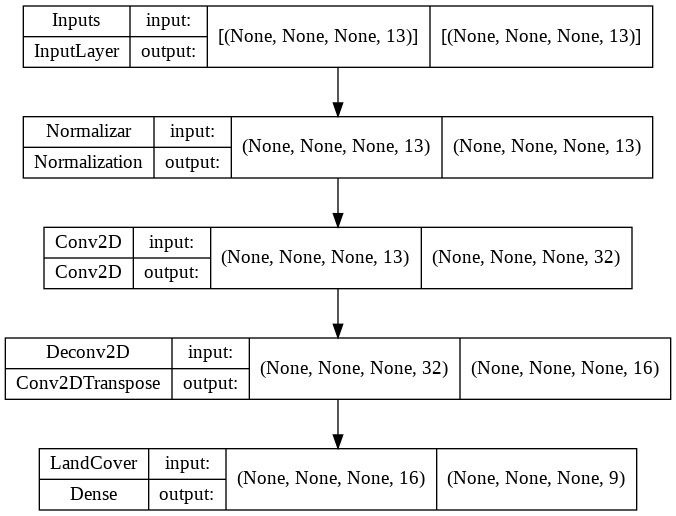

In [21]:
# Como capa de preprocesamiento se Normalizara los valores de las entradas entre -1 y 1.
normalization = tf.keras.layers.Normalization(name="Normalizar")
normalization.adapt(
    training_dataset.map(
        #Mediante la funcion stack podemos apilar todas las capas de entrada en un solo tensor.
        lambda inputs, _: tf.stack([inputs[name] for name in INPUT_BANDS], axis=-1)
    )
)

# Definicion de la arquitectura de nuestra red neuronal, en este caso se tiene una .
fcn_model = tf.keras.Sequential([
    tf.keras.Input(shape=(None, None, len(INPUT_BANDS)), name="Inputs"),
    normalization,

    tf.keras.layers.Conv2D(filters=32, kernel_size=5, activation="relu", name="Conv2D"),

    tf.keras.layers.Conv2DTranspose(filters=16, kernel_size=5, activation="relu", name="Deconv2D"),

    tf.keras.layers.Dense(len(CLASSIFICATIONS), activation="softmax", name="LandCover"),
    ], name="RedTotalmenteConvolucional_FCN")

fcn_model.summary()
tf.keras.utils.plot_model(fcn_model, show_shapes=True)

Se creará un modeo "wrapper". Que nos permitirá insertar los datos mediante un diccionario.

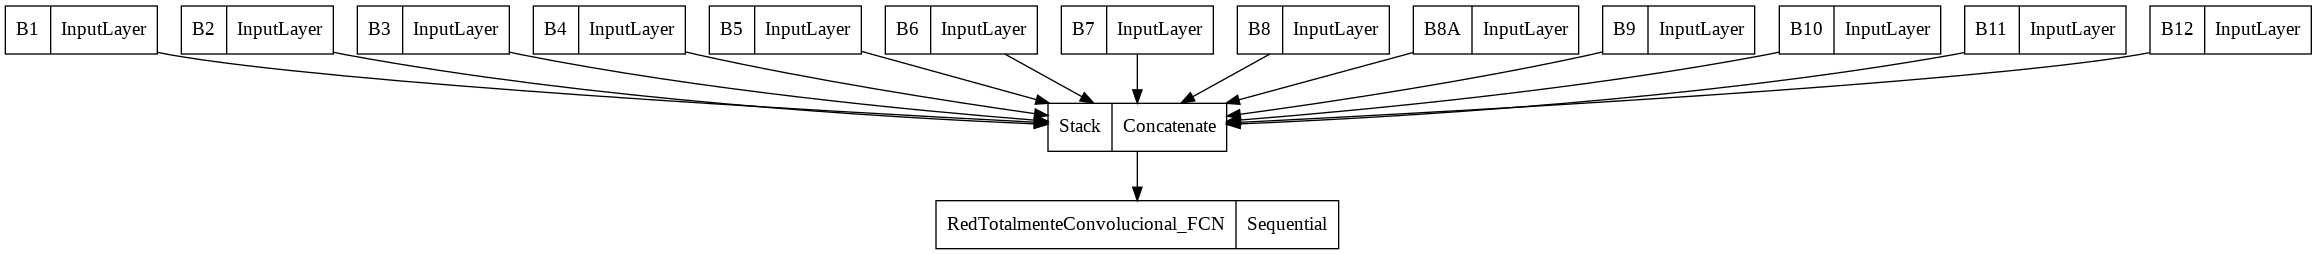

In [22]:
# Definimos las capas del diccionario de entrada.
input_layers = {
    name: tf.keras.Input(shape=(None, None, 1), name=name)
    for name in INPUT_BANDS
}

# Nuestro modelo toma el diccionario de entrada y lo envia a nuestro FCN.
inputs = tf.keras.layers.concatenate(input_layers.values(), name="Stack")
model = tf.keras.Model(input_layers, fcn_model(inputs), name="ClasificadorDeSuperficies")

tf.keras.utils.plot_model(model)

## **Optimizador y Funciones de perdida**

Como funcion de perdida en Clasificacion con Multiclases es recomendable usar funciones de activacion tipo Softmax y funcion de perdida tipo Categorical_Crossentropy.

Como optimizador usaremos el optimizador de Adam ya que es computacionalmente eficiente ya que requiere poca memoria.

In [23]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=[
        tf.keras.metrics.OneHotIoU(
            num_classes=len(CLASSIFICATIONS),
            target_class_ids=list(range(len(CLASSIFICATIONS))),
        )
    ]
)

Como métrica usaremos OneHotIoU (Interseccion sobre union), el cual es una métrica de evaluación común para problemas de segmentación.

## **Entrenamiento**



In [24]:
# Entrenamiento del modelo.
history = model.fit(
    training_dataset,
    validation_data=validation_dataset,
    epochs=50,
)

Epoch 1/50
3/3 [==============================] - 4s 286ms/step - loss: 2.2022 - one_hot_io_u: 0.0401 - val_loss: 2.0223 - val_one_hot_io_u: 0.1230
Epoch 2/50
3/3 [==============================] - 0s 55ms/step - loss: 1.9494 - one_hot_io_u: 0.1184 - val_loss: 1.8107 - val_one_hot_io_u: 0.1524
Epoch 3/50
3/3 [==============================] - 0s 180ms/step - loss: 1.7440 - one_hot_io_u: 0.1278 - val_loss: 1.6209 - val_one_hot_io_u: 0.1782
Epoch 4/50
3/3 [==============================] - 0s 157ms/step - loss: 1.5258 - one_hot_io_u: 0.1411 - val_loss: 1.4897 - val_one_hot_io_u: 0.1886
Epoch 5/50
3/3 [==============================] - 0s 78ms/step - loss: 1.3979 - one_hot_io_u: 0.1479 - val_loss: 1.3865 - val_one_hot_io_u: 0.2014
Epoch 6/50
3/3 [==============================] - 0s 169ms/step - loss: 1.3205 - one_hot_io_u: 0.1559 - val_loss: 1.2986 - val_one_hot_io_u: 0.2084
Epoch 7/50
3/3 [==============================] - 0s 188ms/step - loss: 1.2522 - one_hot_io_u: 0.1654 - val_loss: 

In [25]:
print(history.history.keys())

dict_keys(['loss', 'one_hot_io_u', 'val_loss', 'val_one_hot_io_u'])


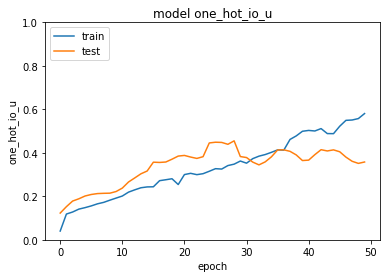

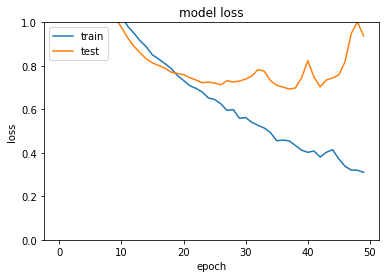

In [26]:
# Grafico de entrenamiento y validacion de OneHotIoU (Interseccion sobre union)
plt.plot(history.history['one_hot_io_u'])
plt.plot(history.history['val_one_hot_io_u'])
plt.ylim([0,1])
plt.title('model one_hot_io_u')
plt.ylabel('one_hot_io_u')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Grafico de entrenamiento y validacion de los valores de perdida
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim([0,1])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [27]:
# Guardamos nuestro modelo.
model.save("model")

2022-07-14 13:00:52.181297: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


# **Prediccion del modelo entrenado**


Obtenemos los datos de entrada, en nuestro caso obtendremos las coordenas cerca de la Laguna Alalay en Cochabamba.

Got patch for (-17.4105469675775, -66.1270748923207)
Lag_Alalay/2016 (512, 512) with 13 bands
  B1:	float64
  B2:	float64
  B3:	float64
  B4:	float64
  B5:	float64
  B6:	float64
  B7:	float64
  B8:	float64
  B8A:	float64
  B9:	float64
  B10:	float64
  B11:	float64
  B12:	float64


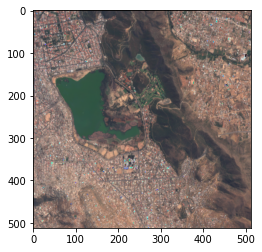

In [28]:
def get_prediction_patch(region: Dict, patch_size: int = 256) -> Tuple[str, np.ndarray]:
  lat = float(region["lat"])
  lon = float(region["lon"])
  year = int(region["year"])

  filename = f"{region['name']}/{year}"
  image = imagen_sentinel2(f"{year}-1-1", f"{year + 1}-1-1")
  patch = get_patch(image, lat, lon, INPUT_BANDS, patch_size, scale=10)
  return (filename, patch)

region = {"name": "Lag_Alalay", "lat": -17.4105469675775, "lon": -66.1270748923207, "year": 2016} #Laguna Alalay
filename, patch = get_prediction_patch(region, patch_size=512)

plt.imshow(render_sentinel2(patch))
print(f"{filename} {patch.shape} with {len(patch.dtype)} bands")
for name in patch.dtype.names:
  print(f"  {name}:\t{patch.dtype[name]}")

## **Prediccion de datos**

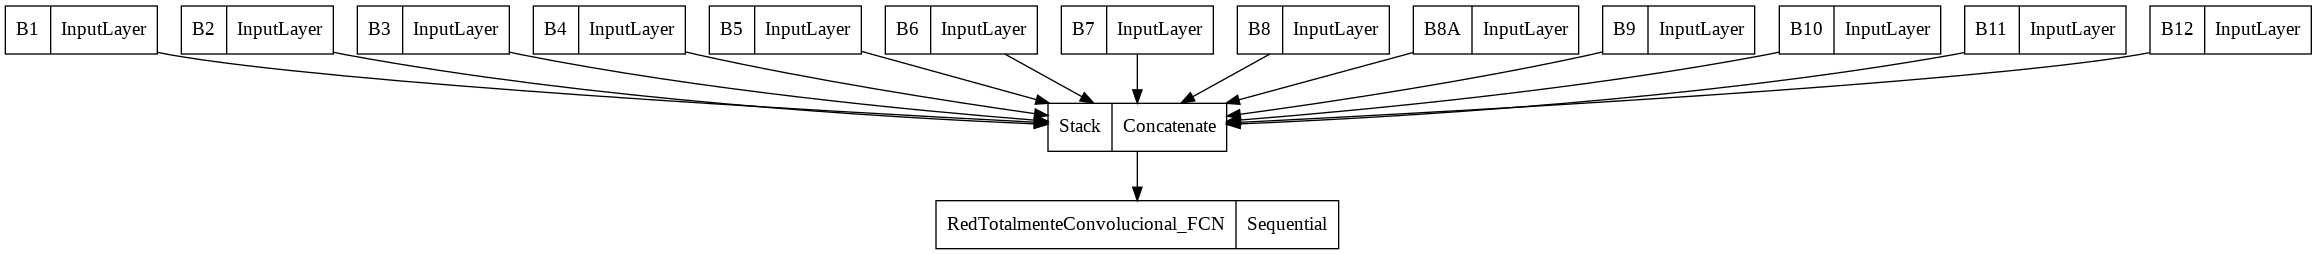

In [29]:
#Cargamos nuestro modelo
model = tf.keras.models.load_model("model")

tf.keras.utils.plot_model(model)

Creamos un diccionario para las entradas y usamos np.stack para apilar todos los elementos somo uno sólo.

In [30]:
print(f"patch: {patch.shape} with {len(patch.dtype)} bands")

inputs_batch = {name: np.stack([patch[name]]) for name in patch.dtype.names}
print("inputs_batch:")
for name, batch in inputs_batch.items():
  print(f"  {name}:\t{batch.dtype} {batch.shape}")

patch: (512, 512) with 13 bands
inputs_batch:
  B1:	float64 (1, 512, 512)
  B2:	float64 (1, 512, 512)
  B3:	float64 (1, 512, 512)
  B4:	float64 (1, 512, 512)
  B5:	float64 (1, 512, 512)
  B6:	float64 (1, 512, 512)
  B7:	float64 (1, 512, 512)
  B8:	float64 (1, 512, 512)
  B8A:	float64 (1, 512, 512)
  B9:	float64 (1, 512, 512)
  B10:	float64 (1, 512, 512)
  B11:	float64 (1, 512, 512)
  B12:	float64 (1, 512, 512)


Ahora se realizara la prediccion para una solo patch.

land_cover: int64 (512, 512)
    Agua
    Arboles
    Hierba
    Vegetacion Inundada
    Cultivos
    Arbustos y matorral
    Areas Edificadas
    Suelo abierto
    Nieve y hielo


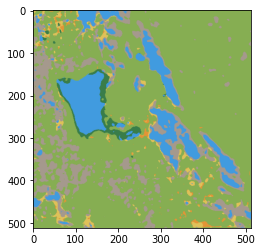

In [31]:
def predict(filename: str, patch: np.ndarray, model_path: str = "model") -> Dict:
  model = tf.keras.models.load_model(model_path)

  # Creamos un diccionario de entrada con un lote que contenga un solo patch.
  inputs_batch = {name: np.stack([patch[name]]) for name in patch.dtype.names}

  # Obtenemos el primer elemento del batch.
  probabilities = model.predict(inputs_batch)[0]

  # Obtenemos los valores de la distribucion de probabilidad para cada clase.
  outputs = np.argmax(probabilities, axis=-1)

  return {
      "name": filename,
      "inputs": patch,
      "outputs": outputs,
  }

results = predict("Lag_Alalay/2016", patch, model_path="model")
land_cover = results["outputs"]
print(f"land_cover: {land_cover.dtype} {land_cover.shape}")

plt.imshow(render_landcover(land_cover))
display_legend()

Creamos los archivos numpy.


In [32]:
def write_to_numpy(results: Dict, predictions_prefix: str = "predictions"):
  filename = f"{predictions_prefix}/{results['name']}.npz"
  #Usaremos la Apache Beam para escribir el archivo en varios sistemas de archivos
  with FileSystems.create(filename) as f:
    #Guardamos nuestros resultados como archivos numpy
    np.savez_compressed(f, inputs=results["inputs"], outputs=results["outputs"])

write_to_numpy(results)

Crearemos un pipeline con Apache Beam para procesar multiples archivos.


In [33]:
puntos_long_lat = [-65.61282092120388,-17.41967421448678]
años = [2016, 2017, 2018, 2019, 2020, 2021, 2022]
regions = [
    {"name": "camp-fire", "lat": puntos_long_lat[1], "lon": puntos_long_lat[0], "year": años[0]},
    {"name": "camp-fire", "lat": puntos_long_lat[1], "lon": puntos_long_lat[0], "year": años[1]},
    {"name": "camp-fire", "lat": puntos_long_lat[1], "lon": puntos_long_lat[0], "year": años[2]},
    {"name": "camp-fire", "lat": puntos_long_lat[1], "lon": puntos_long_lat[0], "year": años[3]},
    {"name": "camp-fire", "lat": puntos_long_lat[1], "lon": puntos_long_lat[0], "year": años[4]},
    {"name": "camp-fire", "lat": puntos_long_lat[1], "lon": puntos_long_lat[0], "year": años[5]},
]

beam_options = PipelineOptions([], direct_num_workers=len(regions))
with beam.Pipeline(options=beam_options) as pipeline:
  (
      pipeline
      | "Create regions" >> beam.Create(regions)
      | "Get patch" >> beam.Map(get_prediction_patch, patch_size=512)
      | "Predict" >> beam.MapTuple(predict, model_path="model")
      | "Write to NumPy" >> beam.Map(write_to_numpy, predictions_prefix="predictions/")
  )

Got patch for (-17.41967421448678, -65.61282092120388)
Got patch for (-17.41967421448678, -65.61282092120388)
Got patch for (-17.41967421448678, -65.61282092120388)
Got patch for (-17.41967421448678, -65.61282092120388)
Got patch for (-17.41967421448678, -65.61282092120388)


Got patch for (-17.41967421448678, -65.61282092120388)


# **Observamos los cambios en el terreno**

Obtenemos imagenes y sus predicciones, en nuestro caso un terreno ubicado en el departamento de Cochabamba cerca a Coari.

In [34]:
def load_results(filename: str) -> Tuple[np.ndarray, np.ndarray]:
  with FileSystems.open(filename) as f:
    npz_file = np.load(f)
    return (npz_file["inputs"], npz_file["outputs"])

def display_land_cover_change(predictions_path: str, start_year: int, end_year: int, min=0.0, max=4000.0):
  # Cargamos y rederizamos las entradas y salidas de nuestro modelo.
  results = [
      load_results(f"{predictions_path}/{year}.npz")
      for year in range(start_year, end_year + 1)
  ]
  inputs = render_sentinel2(np.stack([x for x, _ in results]), min, max)
  outputs = render_landcover(np.stack([y for _, y in results]))

  # Mostramos las imagenes de entrada y salida.
  img_size = 3
  titles = [str(year) for year in range(start_year, end_year + 1)]
  figsize = (img_size * len(titles), img_size * 2)
  figure, plot_rows = plt.subplots(2, len(titles), figsize=figsize, sharex=True, sharey=True)
  figure.tight_layout(pad=0)
  for title, plot, image in zip(titles, plot_rows[0], inputs):
    plot.set_title(title)
    plot.imshow(image)
  for plot, image in zip(plot_rows[1], outputs):
    plot.imshow(image)

  display_legend()

  # Creamos un gif para poder visualizarlo de mejor forma.
  frames = np.concatenate([inputs, outputs], axis=2)
  imageio.mimwrite('cambios_terreno.gif', frames, duration=1)
  return Image(open('cambios_terreno.gif', 'rb').read())

    Agua
    Arboles
    Hierba
    Vegetacion Inundada
    Cultivos
    Arbustos y matorral
    Areas Edificadas
    Suelo abierto
    Nieve y hielo


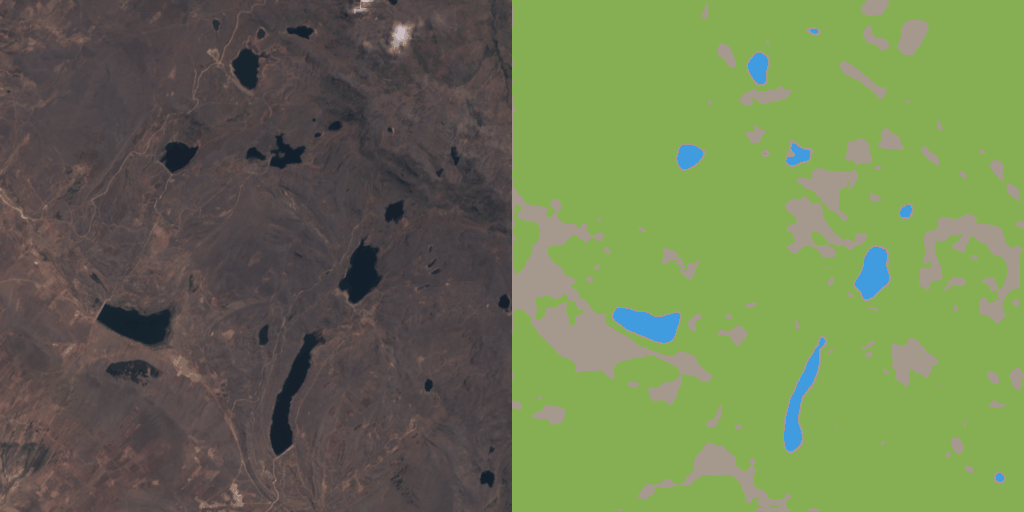

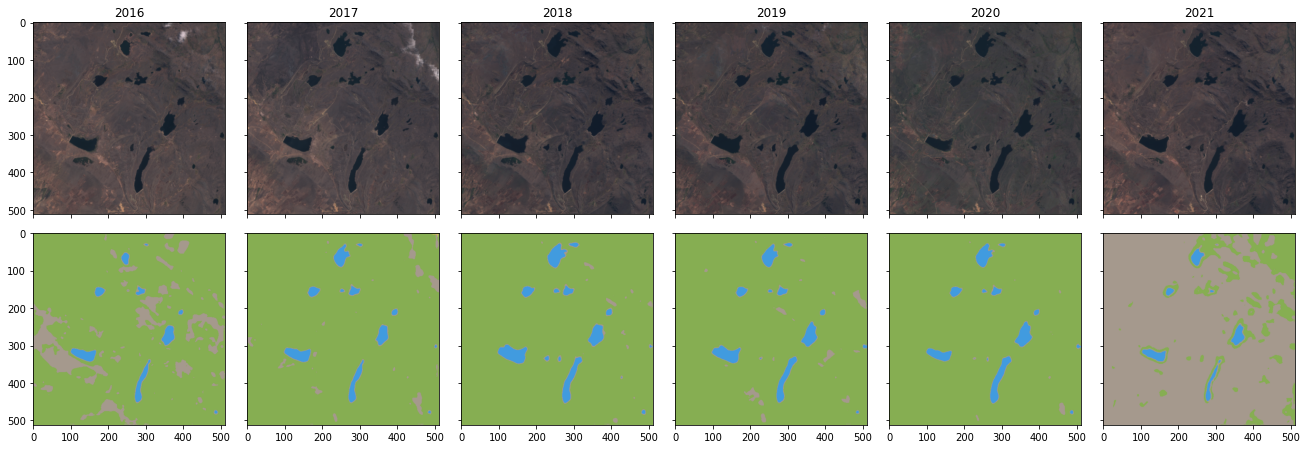

In [35]:
display_land_cover_change(f"predictions/camp-fire", 2016, 2021, max=3500)